<a href="https://colab.research.google.com/github/yosbel-penate/AppEFThreading/blob/master/Clasificador_imagenes_ropa_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [89]:
datos,metadatos=tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [90]:
datos_entrenamiento, datos_prueba=datos['train'], datos['train']

In [91]:
nombres_clases=metadatos.features['label'].names

In [92]:
def normalizar(imagenes, etiquetas):
  imagenes=tf.cast(imagenes, tf.float32)
  imagenes /=255
  return imagenes, etiquetas

In [93]:
datos_entrenamiento=datos_entrenamiento.map(normalizar)
datos_prueba=datos_prueba.map(normalizar)

In [94]:
datos_entrenamiento=datos_entrenamiento.cache()
datos_prueba=datos_prueba.cache()

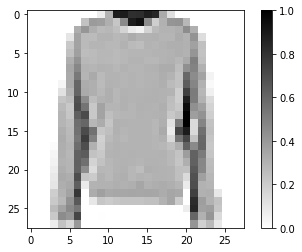

In [95]:
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen=imagen.numpy().reshape(28,28)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

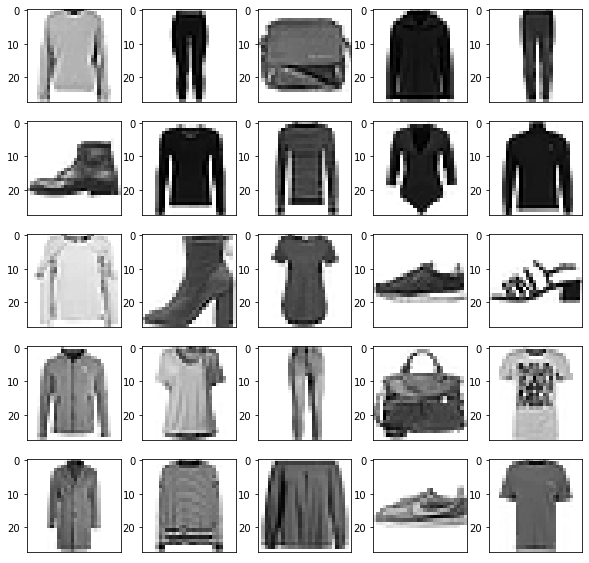

In [96]:
plt.figure(figsize=(10, 10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen=imagen.numpy().reshape((28, 28))
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)

plt.show()

In [97]:
modelo =tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                             tf.keras.layers.Dense(50, activation=tf.nn.relu),
                             tf.keras.layers.Dense(50, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax),
])

In [98]:
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [99]:
num_ej_entrenamiento=metadatos.splits["train"].num_examples
num_ej_pruebas=metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [100]:
TAMANO_LOTE=32
datos_entrenamiento=datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_prueba=datos_prueba.batch(TAMANO_LOTE)

In [101]:
import math
historial=modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 11s 2ms/step - loss: 0.5139 - accuracy: 0.8188
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3825 - accuracy: 0.8624
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3475 - accuracy: 0.8722
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3246 - accuracy: 0.8816
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3144 - accuracy: 0.8835


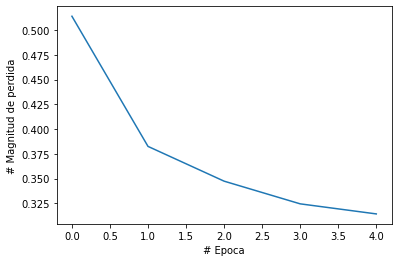

In [102]:
plt.xlabel("# Epoca")
plt.ylabel("# Magnitud de perdida")
plt.plot(historial.history["loss"])

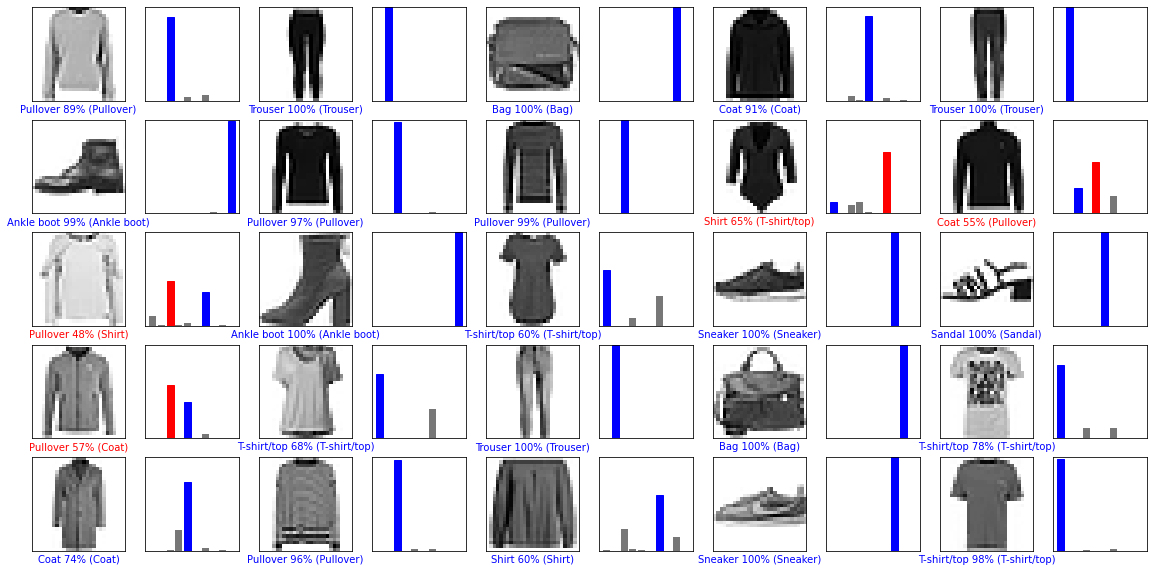

In [104]:
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_prueba.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [105]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

Prediccion: Trouser


In [106]:
#Exportacion del modelo a h5
modelo.save('modelo_exportado.h5')

In [107]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

     |████████████████████████████████| 64 kB 3.2 MB/s 


In [108]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [109]:
#Veamos si si creo la carpeta
!ls

modelo_exportado.h5  sample_data  tfjs_target_dir


In [110]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard1of1.bin  model.json
